In [50]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False



# 차원 축소


많은 경우 머신러닝 문제는 훈련 샘플 각각이 수천 심지어 수백만 개의 특성을 가지고 있다. 이는 훈련을 느리게 할 뿐만 아니라, 앞으로 보게 되겠지만 좋은 솔루션을 찾기 어렵게 만든다. 이를 종종 **차원의 저주**라고 부른다

차원을 축소 시키면 일부 정보가 유실된다. 그래서 훈련속도가 빨라질 순 있지만 성능이 나빠지고 작업 파이프 라인이 복잡하고 유지관리가 어려워질 수 있다. 그러나 어떤 경우는 훈련데이터의 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있다.

## 8.1 차원의 저주

고차원 공간에서는 많은 것이 상당히 다르게 작동한다. 대부분의 훈련 데이터가 서로 멀리 떨어져있다. 물론 이는 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높다는 뜻이다. 이 경우 예측을 위해 훨씬 많은 외삽을 해야 하기 때문에 저차원일 때보다 예측이 더 불안정하다. 간단히 말해 훈련 세트의 차원이 클수록 과대적합 위험이 커진다.

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영 (projection)

대부분의 실전문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않다. 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어있다. 결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 **부분 공간**에 놓여 있다.

In [51]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [52]:

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [53]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [54]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])
X3D_inv = pca.inverse_transform(X2D)

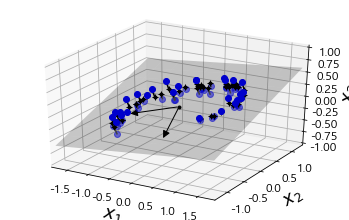

In [55]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

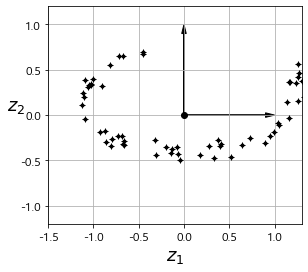

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


투영해서 2D 데이터셋을 얻었다. 하지만 언제나 최선의 방법은 아니다. **스위스 롤**처럼 부분공간이 뒤틀리거나 휘어 있기도 하다.

In [57]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

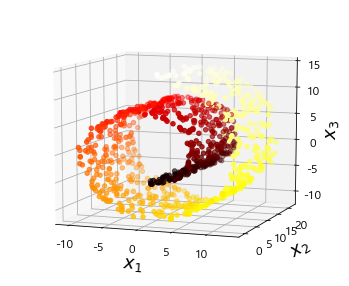

In [58]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

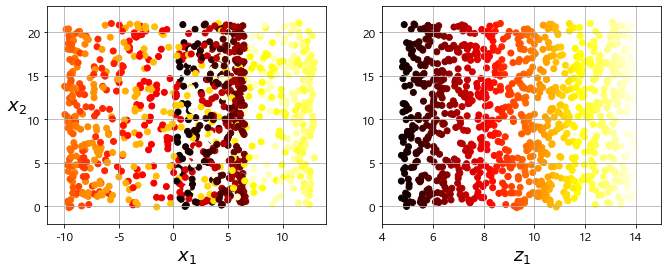

In [59]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

### 8.2.2 매니폴드 학습

스위스롤은 2D **매니폴드**의 한 예이다. 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링 하는 식으로 작동한다. 이를 매니폴드 학습이라고 한다. 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정에 근거한다.   

모델을 훈련시키기 전에 훈련세트의 차원을 감소시키면 훈련속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아니다. 이는 전적으로 데이터셋에 달렸다.

## 8.3 PCA

**주성분 분석**은 가장 인기 있는 차원 축소 알고리즘이다. 먼저 데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영시킨다.

### 8.3.1 분산 보존

![pca](./images/pca.png)
다른 방향으로 투영하는 것보다 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보인다. 이 선택을 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화 하는 축이다.

### 8.3.2 주성분

- 첫번째 축에 직교하고 남은 분산을 최대한 보존하는 두번째 축을 찾는다.    


- 고차원 데이터셋이라면 pca는 이전의 두 축에 직교하는 세 번째 축을 찾으며 데이터셋에 있는 차원의 수 만큼 네 번째, 다섯번째, 축을 찾는다.   


- i번째 축을 정의하는 단위 벡터를 i번째 **주성분(pc)**라고 한다

훈련세트의 주성분을 어떻게 찾을까?  

특잇값 분해(SVD)로 훈련세트 X를 $ U*\Sigma*V^T$로 분해할 수 있다.

In [60]:
from __future__ import division, print_function, unicode_literals

In [61]:
import numpy as np
import os

In [62]:
np.random.seed(42)

In [63]:
np.random.seed(4)
m=60
w1,w2=0.1,0.3
noise=0.1

angles=np.random.rand(m)*3*np.pi/2-0.5
X=np.empty((m,3))
X[:,0]=np.cos(angles)+np.sin(angles)/2+noise*np.random.randn(m)/2
X[:,1]=np.sin(angles)*0.7+noise*np.random.randn(m)/2
X[:,2]=X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [64]:
X_centered=X-X.mean(axis=0)
U,s,Vt=np.linalg.svd(X_centered)
c1=Vt.T[:,0]
c2=Vt.T[:,1]

PCA는 데이터셋의 평균이 0이라고 가정한다. 앞으로 볼 사이킷런의 PCA 클래스는 이 작업을 대신 처리해준다. 그러나 직접 구현하거나 다른 라이브러리를 사용하는 경우는 먼저 데이터를 원점에 맞추는 것을 잊어서는 안된다.

### 8.3.3 d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있다.   

초평면에 훈련세트를 투영하기 위해서는 

$$X_{d-proj} = X * W_d$$

In [65]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련세트를 투영한다.
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

### 8.3.4 사이킷런 사용하기

사이킷런의 PCA 모델은 앞서 한 것 처럼 SVD 분해 방법을 사용하여 구현한다. 

In [66]:
#다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드이다
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
X2D=pca.fit_transform(X)

In [67]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### 8.3.5 설명된 분산 비율

설명된 분산의 비율도 유용한 정보 중 하나이다. 이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.

In [68]:
# 84.2%가 첫 번째 축에 놓여 있고 14.6%가 두 번째 축에 놓여 있음을 알려줌 
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### 8.3.6 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기 보다는 충분한 분산이 될 때까지 더해야 할 차원 수를 선택하는 쪽을 더 선호한다. 

In [69]:
from six.moves import urllib
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

C:\Users\chlgy\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:55: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


In [70]:

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [71]:
pca=PCA()
pca.fit(X_train)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

In [72]:
# 유지하려는 주성분의 수를 지정하기 보단 분산 비율을 0에서 1 사이로 설정하는게 좋음
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X_train)

In [18]:
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced=inc_pca.transform(X_train)

In [21]:

filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [22]:

X_mm=np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size=m//n_batches
inc_pca=IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [23]:
rnd_pca=PCA(n_components=154, svd_solver="randomized")
X_reduced=rnd_pca.fit_transform(X_train)